<a href="https://colab.research.google.com/github/rim-yu/SGU_ANT6320_Assignment/blob/master/MidTermExam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

# Question 1: from fastai.vision import * 문장은 fastai.vision 모듈에 정의되어
# 있는 모든 클래스와 함수 와 상수들을 
# 임포트하는 것이다. (1.1) 이렇게 임포트한 것들 (이름들, names) 을 모두 나열하라. 
# (1.2) 그 중에서 본 노트북에서 실제로 사용하는 것이 무엇인지 기술하라.

# fastai.vision 모듈은 왼쪽 칼럼에서 네모 아이콘을 클릭하면 개인 사용자의 폴더 구조가 나오는데 여기서 
# /usr/local/lib/python3.6/dist-packages/fastai 폴더 내부에 있고, 
# fastai 내부에서 언급하는 다른 패키지들도 다 dist-packages 안에 존재한다.  
# Import 명령의 작동원리에 대해서는 여기 참조: https://docs.python.org/3/tutorial/modules.html#importing-from-a-package




> Answer 1 : 


(1.1)

vision.learner, vision.interpret, vision.transfrom, vision.image, vision.data, vision.gan, vision.model, vision.models.unet. 

(1.2)

vision.learner, vision.interpret, vision.transform, vision.data. 



If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
# Question 2: bs 값은 아래에 나오는 명령어 ImageDataBunch.from_name_re() 의 인풋 파라미터 중의 하나이다.
# (2.1) 이 파라미터의 역할이 무엇인지 설명하라. (2.2) 이 값을 증가시킬 때 어떤 일이 일어날 수 있는지 그리고 이 값을 감소 시킬 때 어떤 일이 일어날 수 있는지 설명하라.  



> Answer 2 : 


(2.1) bs는 batch size를 의미하고, 한 번 망을 병렬적으로 학습시킬 때 몇 개의 데이터를 사용할지 결정하는 변수이다.

(2.2) batch size가 너무 크면 너무 크면 학습 속도가 느려지고, 너무 작으면 각 실행값의 편차가 생겨 전체 결과값이 불안정해질 수 있다. 

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_44.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_81.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_26.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_175.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_49.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
# Question 3: ImageDataBunch.from_name_re() 메소드는 파일 path 로부터 특정 조건을 만족하는 파일들을 찾아서 이를 data 
# 에 집어넣는 일을 한다. 이 data 는 신경망 학습에 사용될 것이므로, 이를 잘 준비하는 것은 매우 중요한 일이다. 
# 위 문장은 data = ImageDataBunch.methodA().methodB() 의 모양을 가지고 있다. 이것은 ImageDataBunch.methodA()  에 생성된 
# object 에 methodB() 를 적용하여 object 를 생성하고 이것을 data 에 할당하라는 뜻이다.(3.1)  methodA가 하는 일을 상세하기 기술하라. 
# methodA는 많은 인풋 파라미터를 가지고 있는데, 이를 고려하여 하는 일을 기술하라. docs.fast.ai 를 참고하라. 
# (3.2) 그리고 methodB (normalize) 가 하는 일도 기술하라. 특히 이 메소드의 인풋 파라미터인 imagenet_stats 를 언급하면서 
# 하는 일을 기술하라.                                  



> Answer 3 : 


(3.1) mathodA는 regular expression을 이용하여 ImageDataBunch를 생성하는 것으로, image folder path(path_img)와 실제 image file들이 있는 path(fnames), 그리고 image file들에 대한 regular expression이 담긴 변수(pat)가 input parameter로 들어갔으며, get_transforms()를 통해 image file들을 변환하고, image file들의 size를 224로 지정한 뒤 batch size(bs)를 입력시킨다. default로 valid_pct=0.2가 설정되어있어 전체 dataset의 20%의 data는 valid dataset으로 분류된다. 

(3.2) methodB, 즉 normalize(imagenet_stats)가 하는 일은 image files들을 정규화하는 것이다. imagenet_stats는 ([0.485, 0.486, 0.406], [0.229, 0.224, 0.225])로, 각 RGB 채널들의 means와 standard deviations를 보여주며 이를 통해 각 이미지 픽셀에 대해 정규화를 수행할 수 있다. 

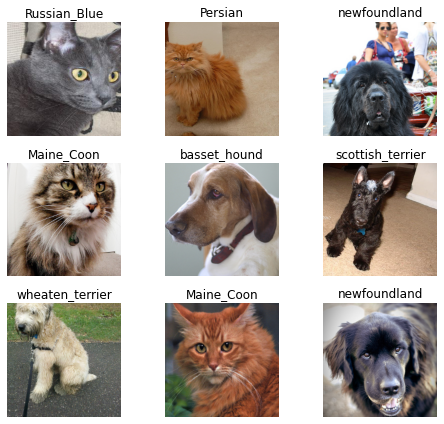

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# Question 4: cnn_learner() 는 함수이다. 파이선에서 함수라는 말은 어느 클래스에도 속하지 않고 독립적으로 존재하는 object
# 라는 뜻이다. ( 파이선 언어에서는 그 언어에 등장하는 모든 것 (모든 이름) 이 다 object 이다. 즉 클래스의 인스턴스도 object이고
# 함수도 object이고 integer 도 object이다. Integer가 object 라는 그 안에 이런 저런 관련된 메소드들의 미리 정의되어 있다는 뜻이다.
# 클래스에 속하는 함수는 메소드라고 구분하여 부른다.)
#  4.1) cnn_learner 는 다음과 같이 정의되어 있는 함수이다. 
#def cnn_learner(data:DataBunch, base_arch:Callable, cut:Union[int,Callable]=None, 
# pretrained:bool=True, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, 
# custom_head:Optional[nn.Module]=None, split_on:Optional[SplitFuncOrIdxList]=None, 
# bn_final:bool=False, init=nn.init.kaiming_normal_, concat_pool:bool=True, **kwargs:Any)->Learner:
#    "Build convnet style learner."
#    meta = cnn_config(base_arch)
#    model = create_cnn_model(base_arch, data.c, cut, pretrained, lin_ftrs, ps=ps, custom_head=custom_head,
#        bn_final=bn_final, concat_pool=concat_pool)
#    learn = Learner(data, model, **kwargs)
#    learn.split(split_on or meta['split'])
#    if pretrained: learn.freeze()
#    if init: apply_init(model[1], init)
#    return learn

# 참고: 
#Learner(data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None,
#        metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, 
#        wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', 
#        callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, 
#        layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None)

# Learner = Trainer for model using data to minimize loss_func with optimizer opt_func.
# ==> Learner 크클스에 의해 생성된 object "learn" (  learn = Learner(data, model, **kwargs) )은 
# 신경망을 학습시키는 (신경망의 weight 파라미터를 학습시키는) 프로그램을 내장하고 있는 object 이다. 
# 이 object 의 특정 method 들을 실행시키는 과정을 통해서 실제로 신경망이 학습된다. 
# 즉 프로그래머는 학습을 시키는 프로그램 을 구성하는 단계 와 그 프로그램을 실행하여 
# 실제로 신경망을 학습시키는 단계를 구분하여 일을 수행한다. 
# cnn_learner 함수와 Learner 클래스가 어느 어느 패키지의 어느 모듈에 정의되어 있는지 확인하라. 

# (4.2) cnn_learner 는 cnn 신경망을 학습시키는 러너 오브젝트를 구성할 때 3개의 인풋 파라미터만 명시적으로 지정했다.
# 지정하지 않은 파라미터는 default 값을 사용하게 된다. 파라미터 뒤에 = 기호가 나오면 그 뒤에 나오는 값이
# default 값이다. 파라미터 중 하나가 pretained:bool = true 인데 이것이 의미하는 바가 무엇인지 설명하라.  만약 
# (4.3) learn = cnn_learner(data, models.resnet34, pretained = false, metrics=error_rate) 
# 를 사용하면 어떤 일이 일어나는지 설명하라.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth




> Answer 4 : 


(4.1) cnn_learner function은 fastai.vision package의 vision.learner modul에 위치하고 있다. learner class는 PyTorch nn package의 nn module에 위치하고 있다. 

(4.2) transfer learning의 경우 모델의 마지막 부분을 자신의 class 숫자에 맞게 변경해야한다. 대부분의 convolutional model은 몇 개의 선형 layer(head라고 부름)로 끝나는데, 마지막 convolutional layer는 모델을 통과한 이미지의 기능을 분석했고 head의 역할은 각 class에 대한 예측 기능을 변환하는 것이다. transfer learning에서 모든 convolutional layer(backbone이라 부름)를 ImageNet에 사전 훈련된 가중치로 유지하지만 임의로 초기화 된 새 head를 정의한다.cnn_learner을 실행할 경우 마지막 convolutional layer에서 사전에 정의된 모델일 경우 pretrained를 무작위로 false로 초기화시켜 layer들을 잘라내고, 다른 layer들을 추가시킨다. 이때 pretrained를 true로 선택하면 backbone이 고정되어 training을 즉시 시작할 수 있다. 

(4.3) pretrained를 false로 선택할 경우 마지막 convolutional layer에서 기존에 있던 layer들을 잘라내고 새로운 layer들을 추가시킨다. 그리고 그 layer들의 값이 무작위로 설정된 값을 학습을 통해 얻어낸다. 

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.fit_one_cycle(4)
# Question 5: (5.1) 이 문장을 실행하면 어떤 일이 수행되는가? 인풋 파라미터 4 는 무엇을 의미하는가?
#(5.2) 이 문장을 실행하면 아래와 같이 epoch 별로 train_loss, valid_loss, error_rate 값이 찍히는데, 
#각 값의 의미가 무엇인지 설명하라.

epoch,train_loss,valid_loss,error_rate,time
0,1.364497,0.312140,0.100135,01:21
1,0.604012,0.279928,0.086604,01:21
2,0.378766,0.231845,0.078484,01:21
3,0.265792,0.227073,0.074425,01:21




> Answer 5 : 


(5.1) 전체 dataset에 대해 한 번 학습을 완료한 숫자를 나타내며 epoch이라고 부른다. 여기서는 4 epochs만큼 학습을 수행하였다. 

(5.2) train_loss는 train dataset에 대한 loss(손실함수)를 나타낸다. valid_loss는 valid dataset에 대한 loss(손실함수)를 나타낸다. error_rate는 에러율을 나타낸다.

In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

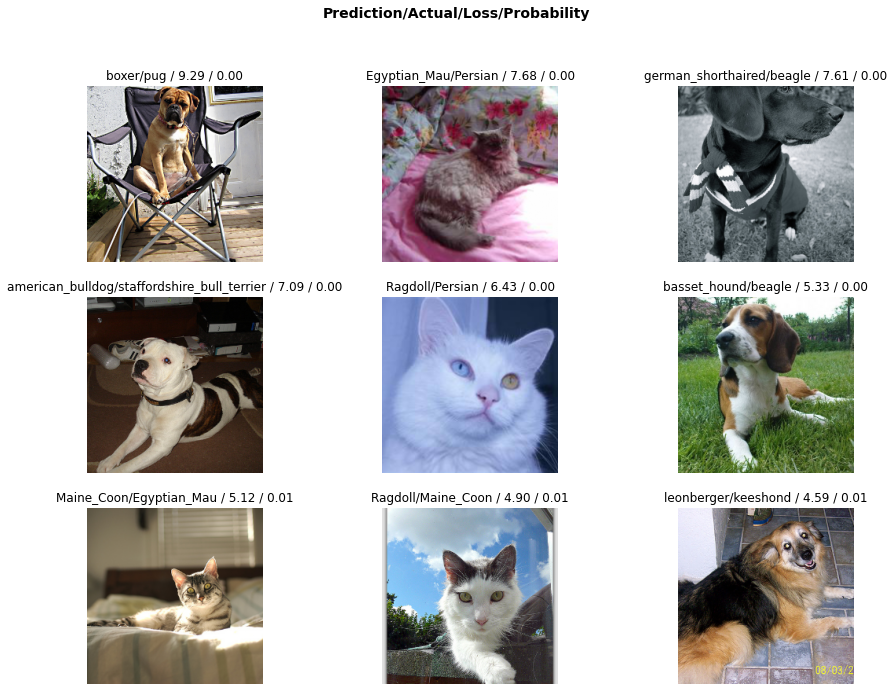

In [18]:
interp.plot_top_losses(9, figsize=(15,11))
# Question 6: 본 노트북에서 학습시키고 실행시키는 신경망은 주어진 인풋 이미지를 분류하는 
# 즉 인풋이미지에 대해서 37 개의 카테고리에 속할 확률을 계산해주는 신경망이다.
#  interp = ClassificationInterpretation.from_learner(learn)
# 는 이 분류 (Classification) 을 해석 (Interpretation) 하는데 사용할 object "interp" 를 생성한다.  
# (6.1) 37 개의 category가 무엇인지 적절한 명령을 실행하여 프린트하라. 
# (6.2) interp.plot_top_losses(9, figsize=(15,11)) 명령어가 하는 일이 무엇인지 대략 기술하라
# (6.3) 아래 그림을 보면 디스플레이된 이미지 위에 두개의 이름과 2개의 값이 기술되어 있다. 이 기술은
# 아래에 디스플레이 되어 있는 이미지의 성격을 기술할 텐데, 각 기술이 해당 이미지에 대해서 말하는 바를 설명하라.
# 9개의 경우에 대해서 다 설명한다 

In [20]:
print(data.classes) # (6.1)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']




> Answer 6 : 


(6.1) 상단 command로 수행. 

(6.2) plot_top_losses function은 가장 loss(손실함수)가 큰 data가 무엇인지 내림차순으로 보여준다. 

(6.3) (9개의 data는 Actual에 해당하는 이미지를 보여주고 있음.) 
1. boxer pug 9.29 0 : pug를 boxer로 예측하였다. 이 때 손실함수는 9.29이고 확률은 0%이다. 
2. Egyptian_Mau Persian 7.68 0 : Persian을 Egyptian_Mau로 예측하였다. 이 때 손실함수는 7.68이고 확률은 0%이다.
3. german_shorthaired beagle 7.61 0 : beagle을 german_shorthaired로 예측하였다. 이 때 손실함수는 7.09이고 확률은 0%이다. 
4. american_bulldog staffordshire_bull_terrier 7.09 0 : staffordshire_bull_terrier을 american_bulldog로 예측하였다. 이 때 손실함수는 7.09이고 확률은 0%이다. 
5. Ragdoll Persian 6.43 0 : Persian을 Ragdoll로 예측하였다. 이 때 손실함수는 6.43이고 확률은 0%이다. 
6. basset_hound beagle 5.33 0 : beagle을 basset_hound로 예측하였다. 이 때 손실함수는 5.33이고 확률은 0%이다. 
7. Maine_Coon Egyptian_Mau 5.12 0.01 : Egyptian_Mau를 Maine_Coon으로 예측하였다. 이 때 손실함수는 5.12이고 확률은 0.01%이다.  
8. Ragdoll Maine_Coon 4.90 0.01 : Maine_Coon을 Ragdoll로 예측하였다. 이 때 손실함수는 4.90이고 확률은 0.01%이다. 
9. leonberger keeshond 4.59 0.01 : keeshound를 leonberger로 예측하였다. 이 때 손실함수는 4.59이고 확률은 0.01%이다. 

In [21]:
doc(interp.plot_top_losses)

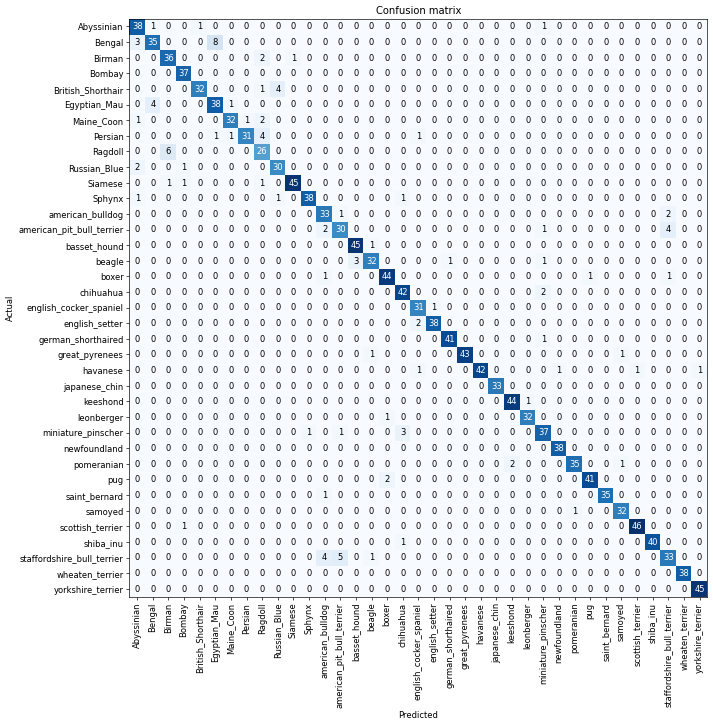

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
# Question 7: 이 명령어는 아래 그림에 보는 것 처럼 confusion matrix 라는 것을 프린트하는데, 이 confusion matrix 는
# 본 신경망이 주어진 이미지를 37개의 카테코리로 얼마나 잘 분류하는지를 전체적으로 보여주는 표이다. 아래 표를 해석하여
# 할 줄 알아야 본 신경망을 제대로 사용한다고 할 수 있다. 아래 표를 해석하고 설명하라. 



> Answer 7 : 

confusion matrix(오차 행렬)을 통해 분류 모델이 얼마나 정확한지 평가할 수 있다. 해당 matrix의 경우 가로는 예측값, 세로는 실제값을 가지고 있고, 대각 행렬로 큰 값을 가지는 것으로 보아 (파란색이 진할수록 값이 큼.) 예측값과 실제값이 동일했던 케이스가 많은 걸로 볼 수 있다. 즉 이 모델은 data들이 37개의 카테고리로 잘 분류되어진 걸로 볼 수 있다.   



In [23]:
interp.most_confused(min_val=2)
# Question 8: 이 문장은 8개의 값을 프린트하는데 이들 값이 어떤 종류의 값인지 설명하라. 

[('Bengal', 'Egyptian_Mau', 8),
 ('Ragdoll', 'Birman', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Persian', 'Ragdoll', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Bengal', 'Abyssinian', 3),
 ('beagle', 'basset_hound', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('Birman', 'Ragdoll', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('pomeranian', 'keeshond', 2),
 ('pug', 'boxer', 2)]



> Answer 8 : 

most_confused function은 잘못 분류되어진 data와 그 data가 무엇으로 예측되었는지, 이와 함께 그 빈도수를 내림차순으로 보여준다. min_val = 2라 하여 그 빈도수가 최소 2가 될 때까지 출력을 하였다.  



## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(1)
# Question 9: 윗 문장들은 신경망을 수정가능한 모드로 바꾸고 (unfreeze) 다시 학습을 시켰는데, 도대체 무엇을 어떻게 
# 학습시켰는가?

epoch,train_loss,valid_loss,error_rate,time
0,0.693426,0.375073,0.118403,01:23




> Answer 9 :


fastai library에서 제공하는 모델은 마지막 fully connected layer를 제외한 layer가 잠겨있는데, 모든 layer를 학습 data에 따라 변하게 만들고 싶다면 수동으로 잠금을 풀어주어야 한다. 이 작업이 unfreeze()이다. 학습을 다시 하기 위해 unfreeze()를 수행하였고, 이번에는 epoch 수를 4에서 1로 감소시켜 다시 fit_one_cycle()을 실행하였다.  

In [0]:
learn.load('stage-1');

In [27]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


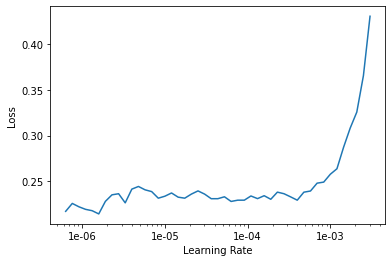

In [28]:
learn.recorder.plot()
# Question 10: 학습 레이트 (lr = learning rate) 가 가로축에 나타나고 loss 가 세로축에 나타난 그래프이다. 
# (10.1) 여기서 learning rate 라는 것이 무엇인지 설명하라. 
# (10.2) loss 가 무엇인지 설명하라. 
# (10.3) 다음 그래프는 무엇을 말하고 있는가?



> Answer 10 : 


(10.1) learning rate는 학습률로 weight(가중치)와 loss(손실함수)의 관계에서 손실이 최적인 가중치를 찾는데 현재점에서 다음점으로 얼만큼 이동할지, 한 번 학습할 때 얼만큼 변화를 주는지를 정하는 parameter이다.  

(10.2) loss는 손실함수로 모델의 출력값과 사용자가 원하는 출력값(정답)의 차이, 즉 오차를 정의하는 함수이다.  
 
(10.3) 이 그래프는 learning rate에 따른 loss의 변화를 보여주는 것으로 loss가 발산하기 전까지 lr을 추적하여 그래프로 나타낸다. 일반적으로 그래프에서 기울기가 가장 가파르게 떨어지는 지적이 최적의 learning rate로 보고 있다. 

In [29]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
# Question 11: (11.1) 윗 문장을 learning rate 를 수정했는데, 이것의 의미는 무엇인가? 
# (11.2) 러닝 레이트를 수정한 결과 무엇이 바뀌었는가?

epoch,train_loss,valid_loss,error_rate,time
0,0.244627,0.210916,0.069689,01:20
1,0.215950,0.205652,0.064953,01:19




> Answer 11 : 


(11.1) 이는 discriminative learning rate(차별적 학습률)로 slice(1e-06, 1e-04)를 learning rate로 입력시킬 경우 신경망의 첫 번째 layer의 learning rate가 1e-06이 되고, 마지막 layer의 learning rate가 1e-04가 된다. 

(11.2) learnig rate를 수정한 결과 : train dataset과 valid dataset의 loss(손실함수)가 감소하였고, error rate가 크게 줄어든 것을 확인할 수 있다.  

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


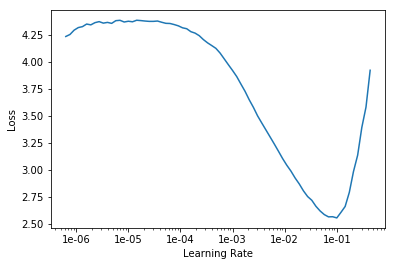

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

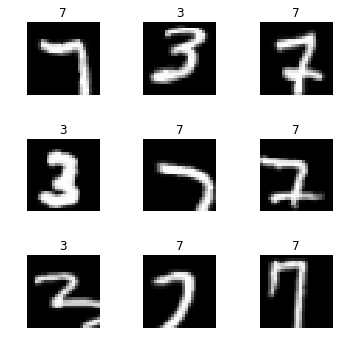

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

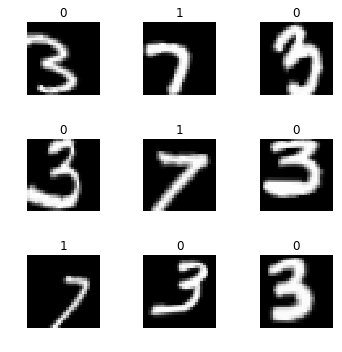

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']